In [77]:
import torch
import numpy as np
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

In [2]:
dataset = torch.load("instances_predictions.pth")

In [3]:
res = dataset[0]
image_id = res["image_id"]
instances = res["instances"]
proposals = res["proposals"]

In [4]:
# Build tensor of proposals of dim nb_proposals x (4 dimensions + 1 score)
proposals_tensors = torch.cat((proposals.proposal_boxes.tensor, torch.sigmoid(proposals.objectness_logits).unsqueeze(1)), 1)
print(proposals_tensors.size())

torch.Size([1000, 5])


In [5]:
#Build tensor of instances of dim nb_instances x (4 dimensions + 1)
instances_tensors = torch.zeros(len(instances), 5)
for ind, instance in enumerate(instances):
    instances_tensors[ind, 0:4]=torch.tensor(instance['bbox'])
    instances_tensors[ind, -1]=torch.tensor(instance['score'])
print(instances_tensors.size())

torch.Size([18, 5])


In [79]:
def scatter(X, ax=None, top=None, color=None, format='proposals', **kwargs):
    '''
    plot scatter points or scatter rectangles
    dim X = nb of points per image x dim of space
    '''
    
    ax = ax or plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])

    N = top if ((top is not None) and  top <= X.size(0)) else X.size(0)
    R = rect_for_plots(X[:N, :], format=format)
    
    if 'mu' in kwargs:
        mu_ini, cov, labels, avg_scores = kwargs['mu'], kwargs['cov'], kwargs['labels'], kwargs['avg_scores']
        mu = rect_for_plots(mu_ini, format=format)
        
        
        ulabels = np.sort(np.unique(labels.cpu().numpy()))[1:]
        ulabels = ulabels[np.argsort(params['avg_score'])]
        colors = cm.rainbow(np.linspace(0, 1, len(ulabels)))
        
        
        
        #Plot l=0 background
        R_temp = R[labels==0]
        for i in range(R_temp.size(0)):
            ax.add_patch(
                        Rectangle((R_temp[i, 0].cpu().data.numpy(), R_temp[i, 1].cpu().data.numpy()), 
                          R_temp[i, 2].cpu().data.numpy(), R_temp[i, 3].cpu().data.numpy(), 
                          fill=False, color='gray', linewidth=1.5, alpha=0.1, linestyle='-'
                                 )
                        )        
        
        #Plot l>1 object clusters
        for l, c in zip(ulabels, colors):
            R_temp = R[labels==l]
            
            #Draw cluster l
            for i in range(R_temp.size(0)):
                ax.add_patch(
                            Rectangle((R_temp[i, 0].cpu().data.numpy(), R_temp[i, 1].cpu().data.numpy()), 
                              R_temp[i, 2].cpu().data.numpy(), R_temp[i, 3].cpu().data.numpy(), 
                              fill=False, color=c, linewidth=1.5, alpha=0.4, linestyle='-'
                                     )
                            )
            #Draw means
            ax.add_patch(
                        Rectangle((mu[int(l) - 1, 0].cpu().data.numpy(), mu[int(l) - 1, 1].cpu().data.numpy()), 
                            mu[int(l) - 1, 2].cpu().data.numpy(), mu[int(l) - 1, 3].cpu().data.numpy(), 
                            fill=False, color=c, linewidth=2, alpha=0.8
                                     )
                        )
            
            #Draw variance
            draw_ellipse(mu_ini[int(l) - 1,0:2].cpu().detach().numpy(), 
                         torch.diag(cov[int(l) -1 , 0:2]).cpu().detach().numpy(), 
                         ax=ax, fc=c
                        )
            draw_ellipse(mu_ini[int(l) - 1,2:4].cpu().detach().numpy(),
                         torch.diag(cov[int(l) - 1, 2:4]).cpu().detach().numpy(), 
                         ax=ax, fc=c
                        )
        
        
    else:
        if color==None:
            reds = cm.get_cmap('Reds')
            colors = np.flip(reds(np.linspace(0, 1, R.size(0))),0)
        else:
            colors=[color for i in range(R.size(0))]

        for i in reversed(range(R.size(0))):
            ax.add_patch(
                        Rectangle((R[i, 0].cpu().data.numpy(), R[i, 1].cpu().data.numpy()), 
                          R[i, 2].cpu().data.numpy(), R[i, 3].cpu().data.numpy(), 
                          fill=False, color=colors[i], linewidth=1.5, alpha=0.5
                                 )
                        )

    ax.axis('equal')
    return None



def rect_for_plots(rects, format='proposals'):
    '''
    input: N x 4 in format (coordinates upper left) x (coordinates bottom right)
    '''

    if format == 'proposals':
        R = torch.zeros_like(rects)
        R[:, 0]=rects[:, 0]
        R[:, 1]=rects[:, 3]
        R[:, 2]=rects[:, 2]-rects[:, 0]
        R[:, 3]=rects[:, 1] - rects[:,3]
        #R[:, 4]=rects[:, 4]
        
    elif format == 'instances':
        R = torch.zeros_like(rects)
        R[:, 0] = rects[:,0] - 0.5*rects[:,2]
        R[:, 1] = rects[:, 1] - 0.5*rects[:, 3]
        R[:, 2] = rects[:, 2]
        R[:, 3] = rects[:, 3]
        #R[:, 4] = rects[:, 4]
        
    
    else:
        X = torch.hstack((rects[:, 0].unsqueeze(1), rects[:, 2].unsqueeze(1)))
        Y = torch.hstack((rects[:, 1].unsqueeze(1), rects[:, 3].unsqueeze(1)))
        x_min, _ = torch.min(X, 1)
        y_min, _ = torch.min(Y, 1)
        x_max, _ = torch.max(X, 1)
        y_max, _ = torch.max(Y, 1)
        w = x_max - x_min
        h = y_max - y_min
        R = torch.hstack(
                (x_min.unsqueeze(1),
                y_min.unsqueeze(1),
                w.unsqueeze(1),
                h.unsqueeze(1))
            )
    
    return R

def draw_ellipse(pos, cov, ax=None, **kwargs):
    if type(pos) != np.ndarray:
        pos = to_numpy(poxs)
    if type(cov) != np.ndarray:
        cov = to_numpy(cov)
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
    width, height = 2 * np.sqrt(s)
    for nsig in range(1, 6):
        ax.add_patch(Ellipse(pos, nsig*width, nsig*height, angle,
            alpha=0.5/nsig, **kwargs))

In [7]:
import detectron2.layers.nms as nms
nms_thr=0.5

inds = nms(proposals.proposal_boxes.tensor, torch.sigmoid(proposals.objectness_logits), nms_thr)
retained_boxes = proposals.proposal_boxes[inds]
retained_boxes = retained_boxes[:10, :]

print(retained_boxes.tensor.size())

torch.Size([10, 4])


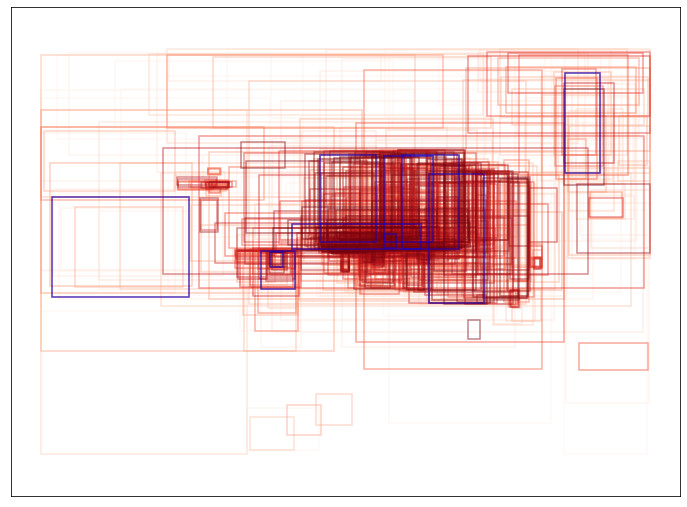

In [8]:
fig=plt.figure(figsize=(12,9))
ax = plt.gca()
scatter(proposals.proposal_boxes.tensor, ax = ax, format='proposals', top=1000)
scatter(retained_boxes.tensor, ax=ax, format='proposals',color='blue')

In [66]:
from detectron2.structures import pairwise_iou

#Naive estimation of the bounding box density

#1- Compute pair-wise IoUs
iou = pairwise_iou(retained_boxes, proposals.proposal_boxes)


#2- Estimate the mixture parameters sequentially
params={'mu':[], 'cov':[], 'pi':[], 'avg_score':[]}

processed=0
proposals_tensor = proposals.proposal_boxes.tensor.clone()
scores = torch.sigmoid(proposals.objectness_logits)

mask = torch.ones(proposals_tensor.size(0))
labels = torch.zeros_like(mask)

for i in range(len(retained_boxes)):
    print('Number of remaining proposals: {}'.format(mask.sum()))
    
    cond = ((iou[i, :] >= nms_thr)*mask).bool()
    labels[cond]= i + 1
    current_cluster=proposals_tensor[cond]
    current_scores=scores[cond]
    
    #Compute mixture parameters
    N = current_cluster.size(0)
    X = current_cluster
    W = current_scores.unsqueeze(1).repeat(1, current_cluster.size(1))
    mu = (X*W).sum(0)/W.sum(0)
    cov = (1/N)*(((X - mu.repeat(X.size(0),1))**2)*W).sum(0)
    pi = N
    
    params['mu'].append(mu)
    params['cov'].append(cov)
    params['pi'].append(pi)
    params['avg_score'].append(current_scores.mean().item())
    
    
    #Suppress non-maximum boxes
    mask[iou[i, :] >= nms_thr] = 0

    processed += N
    print('{} boxes in cluster {} (mean score: {})'.format(N, i, current_scores.mean()))

params['pi']=[params['pi'][i]/processed for i in range(len(params['pi']))]
    
print('{} boxes (/{}) used to estimate the mixture parameters'.format(processed, len(proposals.proposal_boxes)))

Number of remaining proposals: 1000.0
17 boxes in cluster 0 (mean score: 0.8724164366722107)
Number of remaining proposals: 983.0
16 boxes in cluster 1 (mean score: 0.9556933045387268)
Number of remaining proposals: 967.0
11 boxes in cluster 2 (mean score: 0.8643327355384827)
Number of remaining proposals: 956.0
9 boxes in cluster 3 (mean score: 0.9762950539588928)
Number of remaining proposals: 947.0
19 boxes in cluster 4 (mean score: 0.919863760471344)
Number of remaining proposals: 928.0
8 boxes in cluster 5 (mean score: 0.9425230026245117)
Number of remaining proposals: 920.0
12 boxes in cluster 6 (mean score: 0.9014258980751038)
Number of remaining proposals: 908.0
11 boxes in cluster 7 (mean score: 0.9684742093086243)
Number of remaining proposals: 897.0
11 boxes in cluster 8 (mean score: 0.9699453115463257)
Number of remaining proposals: 886.0
7 boxes in cluster 9 (mean score: 0.7633537650108337)
121 boxes (/1000) used to estimate the mixture parameters


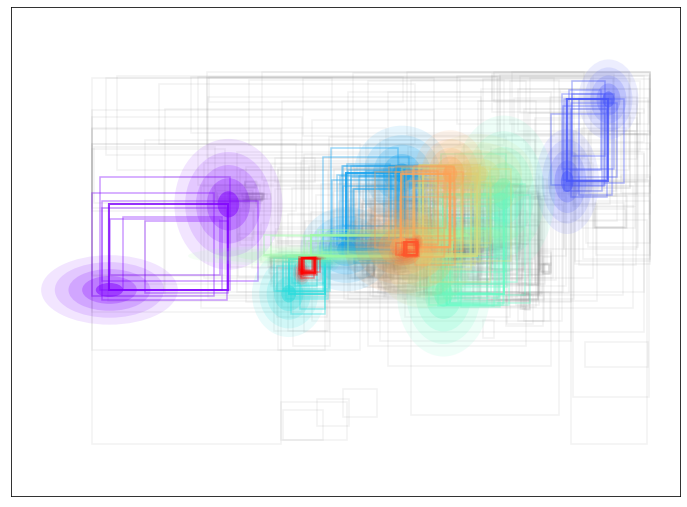

In [80]:
fig=plt.figure(figsize=(12,9))
ax = plt.gca()


'''
scatter(proposals.proposal_boxes.tensor, ax = ax, format='proposals', top=1000)
scatter(torch.vstack(params['mu']), ax=ax, format='proposals',color='blue')
'''


scatter(proposals_tensors, ax=ax, 
        mu = torch.vstack(params['mu']), 
        cov = torch.vstack(params['cov']),
        labels=labels, 
        avg_scores=params['avg_score']
       )

In [65]:
ulabels = np.sort(np.unique(labels.cpu().numpy()))[1:]
print(ulabels)
print(params['avg_score'])
print(ulabels[np.argsort(params['avg_score'])])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.8724164366722107, 0.9556933045387268, 0.8643327355384827, 0.9762950539588928, 0.919863760471344, 0.9425230026245117, 0.9014258980751038, 0.9684742093086243, 0.9699453115463257, 0.7633537650108337]
[10.  3.  1.  7.  5.  6.  2.  8.  9.  4.]
torch.Size([10, 4])


In [74]:
torch.diag(torch.tensor([1, 2, 3]))

tensor([[1, 0, 0],
        [0, 2, 0],
        [0, 0, 3]])